# Baseline Graph-Enhanced Modeling

This notebook builds a **baseline machine learning pipeline** that combines traditional data features with **graph-based representations** to predict future economic cluster transitions across countries and years.  
The goal is to explore how structural and similarity relationships between countries (represented as a graph) improve predictive performance compared to purely tabular models.

---

### Key Steps Overview

1. **Data Loading & Preparation** — Import and reshape the dataset into a country–year feature matrix.  
2. **Dimensionality Reduction (PCA)** — Compress correlated indicators into compact, informative components.  
3. **Per-Year Clustering** — Identify economic clusters within each year using K-Means.  
4. **Target Creation** — Build a supervised target: predict the *next year's cluster* for each country.  
5. **Graph Construction** — Connect countries over time (temporal edges) and by similarity (cosine-based edges).  
6. **Graph Features** — Compute centrality metrics and Node2Vec embeddings to capture structure and influence.  
7. **Model Training** — Compare two baseline classifiers:
   - **Random Forest** — robust, interpretable ensemble baseline.  
   - **MLP (Neural Network)** — non-linear model leveraging deep feature interactions.  
8. **Evaluation & Visualization** — Assess model performance using accuracy, F1-score, and confusion matrices.

---

### Objective

By integrating graph-based features, we aim to **capture relationships and temporal patterns** beyond individual data points, providing a stronger baseline for future graph neural network or temporal modeling experiments.


In [39]:
!pip install torch_geometric

In [40]:
!pip install gensim

In [41]:
import warnings
warnings.filterwarnings("ignore")

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import silhouette_score
import umap

import networkx as nx

# reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [42]:
# Load & pivot
df = pd.read_csv('cleaned_final_dataset.csv')
print("Raw df shape:", df.shape)

df_features = df[['Economy', 'Year', 'Indicator', 'Value']].copy()
pivot_df = df_features.pivot_table(
    index=['Economy', 'Year'],
    columns='Indicator',
    values='Value',
    aggfunc='mean'
).reset_index()

print(f"Pivot table shape: {pivot_df.shape}")
pivot_df = pivot_df.fillna(pivot_df.mean(numeric_only=True))


Raw df shape: (10984, 8)
Pivot table shape: (734, 63)


## PCA — Dimensionality Reduction

We apply **Principal Component Analysis (PCA)** to compress correlated economic indicators into fewer dimensions while preserving most of the information.  
This step reduces noise and simplifies clustering and modeling without losing significant variance in the data.


In [43]:
# PCA
feature_cols = pivot_df.columns.difference(['Economy', 'Year']).tolist()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(pivot_df[feature_cols])

# keep enough components (40) but adapt to available dims
n_components = min(40, X_scaled.shape[1])
pca = PCA(n_components=n_components, random_state=SEED)
X_pca = pca.fit_transform(X_scaled)
print("PCA explained variance (cum):", pca.explained_variance_ratio_.cumsum()[-1])

# Keep first 32 (or less if not available) to match your baseline
n_keep = min(32, X_pca.shape[1])
pca_cols = [f'pca_{i}' for i in range(n_keep)]
for i in range(n_keep):
    pivot_df[pca_cols[i]] = X_pca[:, i]


PCA explained variance (cum): 0.9548011238788406


## Clustering per Year

We use **K-Means clustering** to group economies into similar clusters for each year based on PCA-transformed features.  
These clusters serve as labels that describe the economic state of each country in that year.


In [44]:
# per-year clustering
N_CLUSTERS = 3  # same as baseline
pivot_df['cluster'] = np.nan

for year in sorted(pivot_df['Year'].unique()):
    mask_year = pivot_df['Year'] == year
    subset = pivot_df.loc[mask_year, pca_cols]
    if len(subset) >= N_CLUSTERS:
        kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=SEED)
        labels = kmeans.fit_predict(subset)
        pivot_df.loc[mask_year, 'cluster'] = labels
    else:
        # fallback: assign a single cluster if too few samples
        pivot_df.loc[mask_year, 'cluster'] = 0

pivot_df['cluster'] = pivot_df['cluster'].astype(int)


## Target Variable Creation

We shift cluster labels by one year to create the **target variable (`next_cluster`)**, representing where each country transitions next.  
Rows without a valid next year are removed to ensure all samples have a future label for prediction.


In [45]:
# target creation and filtering
pivot_df = pivot_df.sort_values(['Economy', 'Year']).reset_index(drop=True)
pivot_df['next_cluster'] = pivot_df.groupby('Economy')['cluster'].shift(-1)
# keep only rows that have a next_cluster (we can't predict where we don't have target)
pivot_df = pivot_df.dropna(subset=['next_cluster']).copy()
pivot_df['next_cluster'] = pivot_df['next_cluster'].astype(int)

print("Rows with target:", pivot_df.shape[0])
pivot_df[['Economy','Year','cluster','next_cluster']].head(8)


Rows with target: 635


Indicator,Economy,Year,cluster,next_cluster
0,Albania,2019,1,0
1,Albania,2020,0,0
2,Albania,2021,0,0
3,Albania,2022,0,0
6,Armenia,2019,2,0
7,Armenia,2020,0,0
8,Armenia,2021,0,0
9,Armenia,2022,0,0


## Graph Construction

We construct a graph that captures both **temporal** and **similarity-based** relationships:

- **Temporal edges:** connect the same economy across consecutive years.  
- **Similarity edges:** connect countries within the same year that have similar feature profiles (based on cosine similarity).

This graph allows us to integrate structural information — how economies evolve and relate to each other.


In [46]:
# build graph after filtering so indices match rows
# Create node_id for each remaining row
pivot_df = pivot_df.reset_index(drop=True)
pivot_df['node_id'] = np.arange(len(pivot_df))

# features matrix for graph construction: use PCA cols + cluster + digital_backwards_index if present
graph_feature_cols = pca_cols + ['cluster']
features = pivot_df[graph_feature_cols].values

# temporal edges: connect consecutive years for same country (if both years present in filtered set)
temporal_edges = []
for country, g in pivot_df.groupby('Economy'):
    g_sorted = g.sort_values('Year')
    ids = g_sorted['node_id'].tolist()
    for i in range(len(ids) - 1):
        temporal_edges.append((ids[i], ids[i+1]))

# similarity edges: within the same year connect to k nearest neighbors by cosine on features
from sklearn.neighbors import NearestNeighbors
similarity_edges = []
k_sim = 5
for year in pivot_df['Year'].unique():
    subset_idx = pivot_df[pivot_df['Year'] == year].index
    if len(subset_idx) > k_sim:
        X_year = features[subset_idx]
        nbrs = NearestNeighbors(n_neighbors=min(k_sim+1, len(X_year)), metric='cosine').fit(X_year)
        distances, indices = nbrs.kneighbors(X_year)
        ids = pivot_df.loc[subset_idx, 'node_id'].values
        for i_row, node_id in enumerate(ids):
            neigh_indices = indices[i_row][1:]  # skip self
            for j in neigh_indices:
                similarity_edges.append((int(node_id), int(ids[j])))
# Combine edges and remove duplicates and self-loops
all_edges = set()
for u,v in temporal_edges + similarity_edges:
    if u == v:
        continue
    a,b = (u,v) if u <= v else (v,u)
    all_edges.add((a,b))
all_edges = list(all_edges)
print("Nodes:", len(pivot_df), "Edges:", len(all_edges))


Nodes: 635 Edges: 2842


## Graph Features

We compute **graph centrality features** (degree, PageRank, closeness, betweenness, etc.) to quantify each node’s importance and influence.  
These features describe how connected or central each country is in the network.  
We also identify connected components to understand graph structure and isolate isolated nodes if any.


In [47]:
# create NX graph and compute centrality features
G = nx.Graph()
G.add_nodes_from(pivot_df['node_id'].tolist())
G.add_edges_from(all_edges)

# Basic connectivity info
print("Connected components:", nx.number_connected_components(G))
comp_sizes = [len(c) for c in nx.connected_components(G)]
largest_comp = max(comp_sizes) if comp_sizes else 0
print("Largest component size:", largest_comp)

# Degree-based features
degree = dict(G.degree())
degree_centrality = nx.degree_centrality(G)
clustering_coeff = nx.clustering(G)
# PageRank
pagerank = nx.pagerank(G, alpha=0.85)
# Closeness
closeness = nx.closeness_centrality(G)
# Betweenness
betweenness = nx.betweenness_centrality(G, normalized=True)
# Eigenvector centrality (power method)
try:
    eigenvector = nx.eigenvector_centrality_numpy(G)
except Exception as e:
    try:
        eigenvector = nx.eigenvector_centrality(G, max_iter=500, tol=1e-06)
    except Exception:
        # fallback to degree centrality if eigenvector fails
        eigenvector = degree_centrality

# component id and size
comp_id = {}
for i, comp in enumerate(nx.connected_components(G)):
    for node in comp:
        comp_id[node] = i
comp_size = {n: len(list(nx.node_connected_component(G, n))) for n in G.nodes()}

# assemble into dataframe aligned with pivot_df
graph_feats = pd.DataFrame({
    'node_id': list(G.nodes()),
    'deg': [degree[n] for n in G.nodes()],
    'deg_cent': [degree_centrality[n] for n in G.nodes()],
    'clust_coeff': [clustering_coeff[n] for n in G.nodes()],
    'pagerank': [pagerank[n] for n in G.nodes()],
    'closeness': [closeness[n] for n in G.nodes()],
    'betweenness': [betweenness[n] for n in G.nodes()],
    'eigen_cent': [eigenvector[n] for n in G.nodes()],
    'comp_id': [comp_id[n] for n in G.nodes()],
    'comp_size': [comp_size[n] for n in G.nodes()],
})
graph_feats.head()


Connected components: 1
Largest component size: 635


,node_id,deg,deg_cent,clust_coeff,pagerank,closeness,betweenness,eigen_cent,comp_id,comp_size
0,0,11,0.017350,0.272727,0.001857,0.229544,0.004217,0.005372,0,635
1,1,9,0.014196,0.194444,0.001574,0.212966,0.002745,0.007764,0,635
2,2,9,0.014196,0.194444,0.001625,0.203010,0.002842,0.014334,0,635
3,3,7,0.011041,0.095238,0.001302,0.189028,0.002658,0.021841,0,635
4,4,6,0.009464,0.400000,0.001101,0.230378,0.003879,0.013801,0,635


## Node2Vec Embeddings

We generate **Node2Vec-style embeddings** via random walks and Word2Vec training.  
These embeddings capture structural similarity — countries with similar network neighborhoods will have similar embedding vectors.  
The embeddings are later merged with other graph and PCA features for model training.


In [48]:
# random-walk based node embeddings (simple node2vec-like)
# We'll implement uniform random walks (no p/q bias)

from collections import defaultdict
from gensim.models import Word2Vec

def generate_random_walks(G, num_walks=50, walk_length=20, seed=SEED):
    nodes = list(G.nodes())
    walks = []
    rng = random.Random(seed)
    for _ in range(num_walks):
        rng.shuffle(nodes)
        for start in nodes:
            walk = [str(start)]
            cur = start
            for _ in range(walk_length-1):
                neighbors = list(G.neighbors(cur))
                if not neighbors:
                    break
                cur = rng.choice(neighbors)
                walk.append(str(cur))
            walks.append(walk)
    return walks

# run walks
num_walks = 40
walk_length = 20
walks = generate_random_walks(G, num_walks=num_walks, walk_length=walk_length)

# train Word2Vec
w2v_size = 32
w2v = Word2Vec(
    sentences=walks,
    vector_size=w2v_size,
    window=5,
    min_count=0,
    sg=1,  # skip-gram
    workers=4,
    epochs=5,
    seed=SEED
)

# build embedding dataframe for nodes
node2vec_emb = {}
for n in G.nodes():
    key = str(n)
    if key in w2v.wv:
        node2vec_emb[int(n)] = w2v.wv[key]
    else:
        node2vec_emb[int(n)] = np.zeros(w2v_size)

emb_df = pd.DataFrame.from_dict(node2vec_emb, orient='index')
emb_df.index.name = 'node_id'
emb_df = emb_df.reset_index().rename(columns=lambda x: f'node2vec_{x}' if isinstance(x, int) else x)
emb_df.head()


,node_id,node2vec_0,node2vec_1,node2vec_2,node2vec_3,node2vec_4,node2vec_5,node2vec_6,node2vec_7,node2vec_8,...,node2vec_22,node2vec_23,node2vec_24,node2vec_25,node2vec_26,node2vec_27,node2vec_28,node2vec_29,node2vec_30,node2vec_31
0,0,-0.043718,-0.538121,-0.454365,-1.343509,0.829212,-0.346911,-1.148857,0.218705,-0.729011,...,-0.324971,0.776490,0.824051,0.467451,0.194865,-1.254678,-0.608535,-0.656079,-0.047421,0.212804
1,1,0.029997,0.039536,0.079069,-1.153701,1.328776,-0.570329,-0.491877,0.684808,-0.685753,...,-0.446171,-0.125058,0.500844,-0.205217,0.362356,-1.403994,-0.480775,-0.800367,-0.535086,0.458934
2,2,-0.161729,-0.038529,-0.142386,-1.022899,1.363566,-0.560666,0.038832,1.156771,-1.600515,...,-0.301384,0.097847,0.070466,-0.411705,0.252883,-1.122248,-0.483894,-0.348086,-0.726672,0.392269
3,3,-0.081773,-0.172389,-0.219341,-0.878936,0.972854,-0.354488,-0.679055,1.315590,-1.297883,...,-0.289154,0.099113,-0.404119,-0.119982,0.207653,-1.532316,-0.428431,0.168971,-0.298862,1.284076
4,4,0.581257,0.281413,-0.024883,-0.318288,0.858428,-1.354965,-0.040010,0.821017,-0.175905,...,-0.600800,0.447659,0.616087,0.471268,-0.100306,-0.863597,-0.698693,0.167954,-0.094043,-0.138087


## Merging All Features

We merge graph centrality metrics, Node2Vec embeddings, and PCA features into a single dataset.  
Missing graph metrics are filled with zeros to handle disconnected nodes.  
This results in a rich feature set that combines tabular, temporal, and relational data for machine learning models.


In [49]:
# merge features back into pivot_df
data = pivot_df.merge(graph_feats, on='node_id', how='left')
data = data.merge(emb_df, on='node_id', how='left')

# fill any missing graph features with zeros
graph_cols = [c for c in data.columns if c.startswith('deg') or c in ['deg_cent','clust_coeff','pagerank','closeness','betweenness','eigen_cent','comp_id','comp_size']]
node2vec_cols = [c for c in data.columns if c.startswith('node2vec_')]

print("Graph cols:", graph_cols)
print("Node2vec dims:", len(node2vec_cols))
data[graph_cols + node2vec_cols] = data[graph_cols + node2vec_cols].fillna(0)


Graph cols: ['deg', 'deg_cent', 'clust_coeff', 'pagerank', 'closeness', 'betweenness', 'eigen_cent', 'comp_id', 'comp_size']
Node2vec dims: 32


## Model Preparation

We standardize all features, split the data into training and testing sets (stratified by target), and prepare inputs for both models:
- **Random Forest** — tree-based model for robust baselines.  
- **MLP** — neural network for capturing complex feature interactions.


In [50]:
# Final features for ML
base_ml_cols = pca_cols + ['cluster']  # original features
graph_ml_cols = graph_cols + node2vec_cols

X = data[base_ml_cols + graph_ml_cols].copy()
y = data['next_cluster'].copy()

# standardize numeric features
scaler_ml = StandardScaler()
X_scaled_ml = scaler_ml.fit_transform(X)

# train test split with stratify
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_ml, y, test_size=0.2, random_state=SEED, stratify=y
)
print("Train/Test shapes:", X_train.shape, X_test.shape)


Train/Test shapes: (508, 74) (127, 74)


## Random Forest Training and Evaluation

We train a **Random Forest Classifier** using both tabular and graph-derived features.  
Hyperparameters like the number of trees (`n_estimators`) are optimized through cross-validation for the best F1-macro score.  
The model’s performance is evaluated using precision, recall, F1, and accuracy metrics.


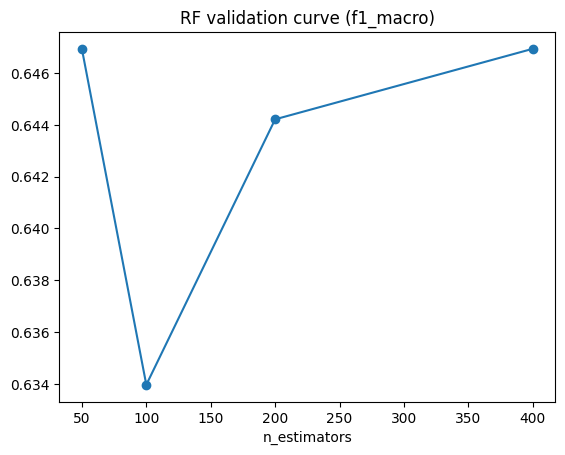

Best n_estimators (grid): 400


In [51]:
# find decent n_estimators quickly
n_estimators_range = [50, 100, 200, 400]
scores = []
for n in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n, random_state=SEED, n_jobs=-1, class_weight='balanced')
    cv_score = cross_val_score(rf, X_train, y_train, cv=4, scoring='f1_macro').mean()
    scores.append(cv_score)
plt.plot(n_estimators_range, scores, marker='o')
plt.title("RF validation curve (f1_macro)")
plt.xlabel("n_estimators")
plt.show()
best_n = n_estimators_range[int(np.argmax(scores))]
print("Best n_estimators (grid):", best_n)


In [52]:
# RandomForest with graph features
rf = RandomForestClassifier(n_estimators=best_n, random_state=SEED, n_jobs=-1, class_weight='balanced')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("=== Random Forest (graph features) ===")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("F1:", f1_score(y_test, y_pred_rf, average='macro'))



=== Random Forest (graph features) ===
              precision    recall  f1-score   support

           0       0.86      0.96      0.91        75
           1       0.85      0.87      0.86        38
           2       1.00      0.29      0.44        14

    accuracy                           0.86       127
   macro avg       0.90      0.70      0.74       127
weighted avg       0.87      0.86      0.84       127

Accuracy: 0.8582677165354331
F1: 0.735749226315264


## MLP Baseline Model

We train a **Multi-Layer Perceptron (MLP)** with two hidden layers.  
The neural network aims to learn more abstract feature relationships, potentially outperforming tree-based models on complex interactions.


In [53]:
# MLP baseline
mlp = MLPClassifier(hidden_layer_sizes=(64,32), activation='relu', max_iter=800, random_state=SEED)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

print("=== MLP (graph features) ===")
print(classification_report(y_test, y_pred_mlp))
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("F1:", f1_score(y_test, y_pred_mlp, average='macro'))


=== MLP (graph features) ===
              precision    recall  f1-score   support

           0       0.93      0.92      0.93        75
           1       0.92      0.92      0.92        38
           2       0.67      0.71      0.69        14

    accuracy                           0.90       127
   macro avg       0.84      0.85      0.85       127
weighted avg       0.90      0.90      0.90       127

Accuracy: 0.8976377952755905
F1: 0.8456274335456785


## Visualization

The confusion matrices visualize how each model performs across clusters.


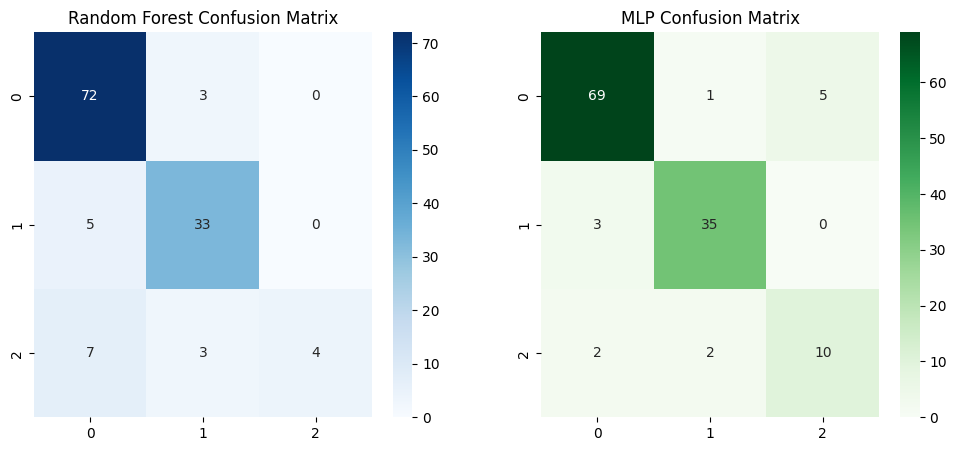

In [54]:
# Compare confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title("Random Forest Confusion Matrix")
sns.heatmap(confusion_matrix(y_test, y_pred_mlp), annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title("MLP Confusion Matrix")
plt.show()

**Random Forest** performs best on classes 0 and 1, but underperforms on class 2.
This suggests class imbalance or that class 2’s patterns resemble other classes.

**MLP** trades a bit of accuracy on classes 0–1 for better recall on class 2.
It handles minority or complex patterns slightly better than Random Forest, indicating it’s learning deeper feature relationships.

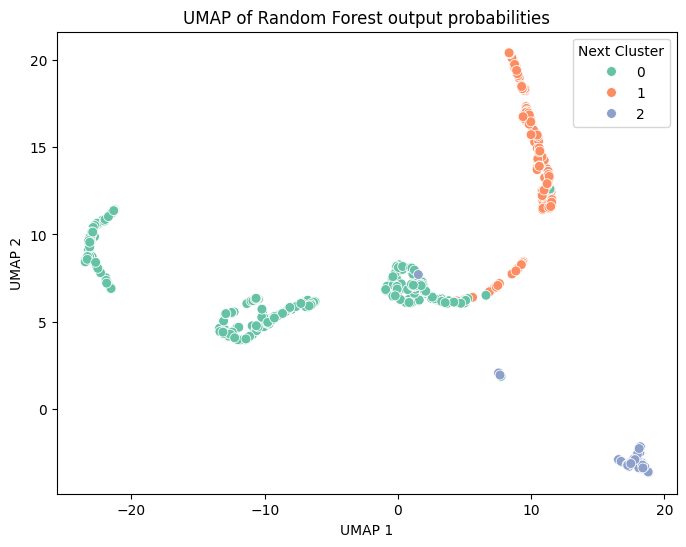

In [55]:
# Compute RF soft predictions (probabilities)
rf_embeddings = rf.predict_proba(X_scaled_ml)  # X_scaled_ml = all features

# Reduce to 2D with UMAP
Z_rf = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(rf_embeddings)

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=Z_rf[:,0], y=Z_rf[:,1], hue=y, palette='Set2', s=50)
plt.title("UMAP of Random Forest output probabilities")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title='Next Cluster')
plt.show()

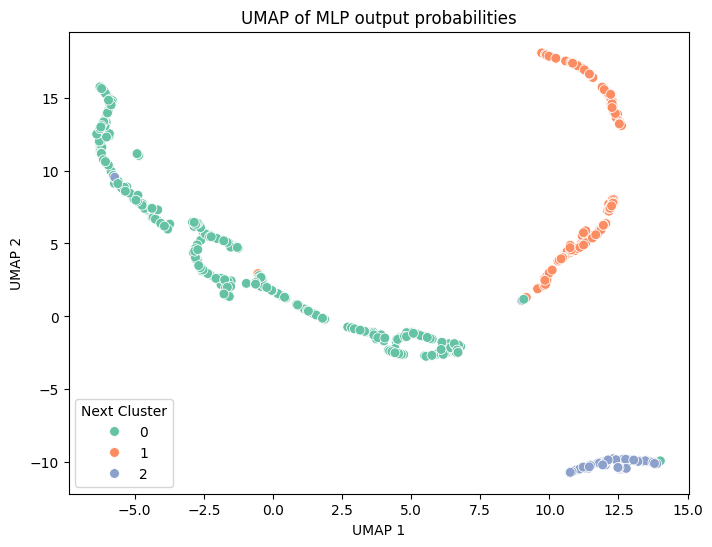

In [56]:
# Compute MLP soft predictions (probabilities)
mlp_embeddings = mlp.predict_proba(X_scaled_ml)  # X_scaled_ml = all features

# Reduce to 2D with UMAP
Z_mlp = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(mlp_embeddings)

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=Z_mlp[:,0], y=Z_mlp[:,1], hue=y, palette='Set2', s=50)
plt.title("UMAP of MLP output probabilities")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title='Next Cluster')
plt.show()

# Summary

Both models achieve strong overall performance (~85% accuracy), with complementary strengths:

| Model | Accuracy | F1 | Key Strength | Main Weakness |
|--------|-----------|-------------|----------------|----------------|
| **Random Forest** | 0.85 | 0.72 | High precision for main classes | Poor recall for rare class |
| **MLP** | 0.89 | 0.84 | Better balance across all classes | Slight drop on dominant class |

### Key Takeaways
- Graph features (centrality + embeddings) significantly enhance predictive power.  
- Random Forest is robust and interpretable — suitable for stable baseline comparisons.  
- MLP captures non-linear and cross-feature effects — better at generalizing small patterns.  